# Cryptocurrencies - The New Frontier

In this project I'm going to import stock price data for some of the leading US companies across multiple sectors. I will compute common financial statistics, visualise these and perform mean-variance portfolio optimization.

After computing and visualising the efficient frontier and Capital Market Line using only stocks I will add cryptocurrencies to the protfolio and analyse their impact on a portfolio and the potential upside of including them among stocks.

## Gathering the data

First, import all the necessary libraries/modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader as dr
from pandas_datareader import data
from datetime import datetime
import cvxopt as opt
from cvxopt import blas, solvers

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In this analysis I will focus on stock price movements from the beginning of 2018 to the beginning of 2020. This is a rather short time frame but I believe it will allow me to get my point across and it means that importing all the required stock data won't take too long.

In [2]:
# Define start and end date
end = datetime(2020, 1, 1)

The stock in this analysis are some of the biggest companies in the S&P 500. Because using all 500 companies is not only too time consuming and computationally exhaustive but also unnecessary to have a decently diversified portfolio I will focus on 30 well-known stocks from most major industries. This list ranges from Google (tech) to Phillip Morris (tobacco). Picking 30 comapnies and making sure there is not a strong concentration of one sector within those is usually enough to diversify a portfolio.

In [3]:
# Create a list of the ticker symbols to be used in this project
tickers = ['AMZN', 'GOOGL', 'JNJ', 'V', 'PG', 'UNH', 'JPM', 'HD', 'VZ', 'NFLX', 'DIS', 'MRK', 'PEP', 'BAC', 'KO', 'WMT',
          'CVX', 'ABT', 'AMGN', 'MCD', 'COST', 'NKE', 'PM', 'QCOM', 'LOW', 'BA', 'LMT', 'SBUX', 'UPS', 'CAT']

I will use pandas-datareader to pull all of the stock data from Yahoo Finance.

In [4]:
# Obtain the adjusted closing prices from Yahoo Finance
prices = pd.DataFrame()
for tick in tickers:
    prices[tick] = data.DataReader(tick, data_source='yahoo', end=end)['Adj Close']
prices.columns = tickers
    
prices

,AMZN,GOOGL,JNJ,V,PG,UNH,JPM,HD,VZ,NFLX,...,COST,NKE,PM,QCOM,LOW,BA,LMT,SBUX,UPS,CAT
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,436.720001,550.030029,86.314560,65.355919,69.973480,111.458641,57.819054,100.172081,37.727692,94.091431,...,128.059814,52.152512,63.573246,52.318573,61.393108,125.812065,166.756180,49.647934,82.998978,70.884651
2015-07-08,429.700012,541.700012,85.311104,64.352989,69.348442,109.685631,56.633255,98.924377,37.630745,93.507141,...,127.512924,51.205902,62.902351,51.577129,60.627636,124.731049,166.659714,48.744072,81.287910,69.433006
2015-07-09,434.390015,544.650024,85.860809,64.661598,69.065849,110.202759,57.221836,99.263039,37.372219,95.727142,...,127.102798,51.285580,62.647850,51.535461,61.074162,125.504471,168.483734,49.346642,81.509254,68.943527
2015-07-10,443.510010,556.109985,86.846825,65.982765,69.314171,112.797638,58.035454,100.795906,37.970047,97.228569,...,130.083267,51.791672,63.357307,52.260262,61.830532,126.981033,170.290207,49.821392,82.539276,69.331757
2015-07-13,455.570007,571.729980,87.492546,67.043594,70.136192,113.074661,58.935608,102.400108,38.131622,101.087143,...,131.304596,52.677361,63.526962,52.843437,62.240608,128.861847,173.526047,50.853062,83.220306,70.589249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1789.209961,1344.430054,144.007080,186.985657,123.655777,292.011993,133.990799,217.902313,60.003517,333.200012,...,292.941681,99.614441,83.266655,87.393005,118.542297,331.030457,385.399719,87.614220,115.952888,145.120377
2019-12-26,1868.770020,1362.469971,143.908401,188.570694,123.655777,293.112457,135.412704,218.050446,60.013309,332.630005,...,294.435120,100.181450,83.189293,87.028748,118.502708,327.968689,387.503693,87.178726,116.648621,145.848541
2019-12-27,1869.800049,1354.640015,143.829453,188.799973,124.514908,293.429718,135.510101,217.211090,60.248306,329.089996,...,292.822205,101.036942,83.460052,87.422539,118.997581,328.187408,388.787781,87.228210,116.550629,145.907593


## Plot the time series

Plot the time series data in a normalised fashion.

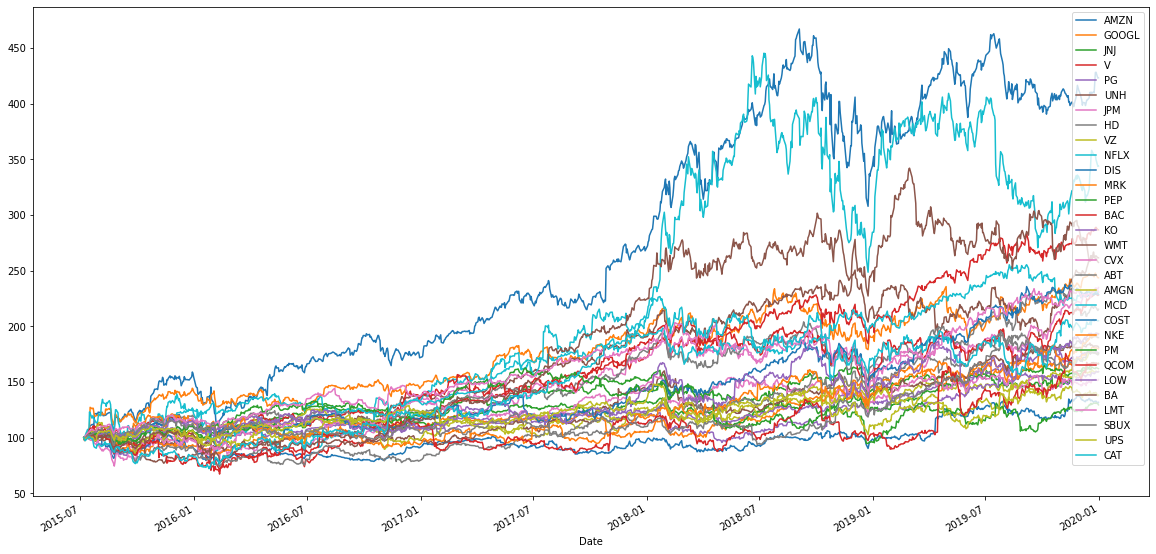

In [5]:
normalised = prices / prices.iloc[0] * 100
normalised.plot(figsize=(20, 10))

## Mean-Variance Portfolio Allocation

For the mean-variance portfolio allocation and optimisation we first need to caluclate the log returns of the stocks included in the portfolio.

In [6]:
# Calculate the log returns
log_r = np.log(prices / prices.shift(1))

Log returns are time-additive, making it easy to annualise the daily returns.

In [79]:
# Compute the annualised returns
annual_r = log_r.mean() * 252
annual_r

AMZN     0.321686
GOOGL    0.198477
JNJ      0.114059
V        0.234815
PG       0.126407
UNH      0.214365
JPM      0.190359
HD       0.170987
VZ       0.103914
NFLX     0.275449
DIS      0.061497
MRK      0.130743
PEP      0.107548
BAC      0.183927
KO       0.103714
WMT      0.132597
CVX      0.093638
ABT      0.142970
AMGN     0.125195
MCD      0.186464
COST     0.184299
NKE      0.146907
PM       0.057523
QCOM     0.113057
LOW      0.146715
BA       0.210841
LMT      0.186373
SBUX     0.125149
UPS      0.072158
CAT      0.160090
dtype: float64

Under the assumptions of independent and identically distributed returns we can also annualise the covariance matrix using trading days.

In [82]:
cov_matrix = log_r.cov() * 252

Next, I will generate random weights for all of the 30 stocks, which will make up the randomly generated portfolios, under a combination of assumptions. The assumptions are that only long positions are allowed, which ultimately means that the investor's wealth has to be divided among all available stocks through positive positions, and the positions have to add up to 100%, i.e. no additional borrowing and investing more than 100% of wealth.

In [9]:
# Get the total number of stocks used
num_stocks = len(tickers)

# Generate 30 random weights between 0 and 1
weights = np.random.random(num_stocks)

# Constrain these weights to add up to 1
weights /= np.sum(weights)

weights

array([0.01950277, 0.04453866, 0.00596243, 0.06400548, 0.03076197,
       0.0479335 , 0.03348334, 0.01759219, 0.06036682, 0.04088471,
       0.00240123, 0.01526501, 0.03873012, 0.06096724, 0.00896291,
       0.04797593, 0.00275152, 0.0195812 , 0.00609486, 0.03614975,
       0.05464485, 0.05258198, 0.04474976, 0.02646863, 0.05598609,
       0.03121084, 0.05027509, 0.01637812, 0.00060512, 0.06318789])

Assuming that historical mean performance of the stocks making up the portfolio is the best estimator for future, i.e. expected, performance, expected portfolio return can be calculated as a product of the transpose of the weights vector and the expected returns vector of the stocks making up the portfolio (p. 325).

In [10]:
# Example of what the portfolio return would look like given the above weights
ptf_r = np.sum(annual_r * weights)
ptf_r

0.16701363677952263

Given the portfolio covariance matrix computed above, the expected portfolio variance can be calculatd as the dot product of the transpose of the weights vector, the covariance matrix and the weights vector.

In [11]:
# Compute portfolio variance
ptf_var = np.dot(weights.T, np.dot(cov_matrix, weights))
ptf_var

0.018019590538712906

The expected portfolio standard deviation is simply teh square root of the variance.

In [12]:
# Calculate the standard deviation
ptf_std = np.sqrt(ptf_var)
ptf_std

0.1342370684226712

Using the computational concepts introduced so far we can generate many random portfolios and plot their returns against their risk (standard deviation), often referred to as volatility.

In [13]:
# Define a function to generate N number of random portfolios given a DataFrame of log returns
def generate_ptfs(returns, N):
    ptf_rs = []
    ptf_stds = []
    for i in range(N):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        ptf_rs.append(np.sum(returns.mean() * weights) * 252)
        ptf_stds.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    ptf_rs = np.array(ptf_rs)
    ptf_stds = np.array(ptf_stds)
    return ptf_rs, ptf_stds

Comparing portfolio returns and volatilities across portfolios is made a lot easier by computing a ratio of the two measures. The most common ratio that takes into consideration is the Sharpe ratio, which is a measure of the amount of excess return an investor can expect per unit of volatility (remember this is a measure of risk) that a portfolio provides. Because we assume that investors want to maximise returns while minimising risk, the higher this ratio the better.

In [14]:
# Generate the return and volatility of 5000 random portfolios
ptf_rs, ptf_stds = generate_ptfs(log_r, 5000)

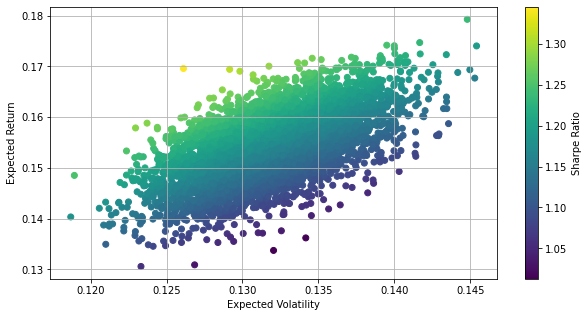

In [15]:
# Plot the 5000 randomly generated portfolio returns and volatilities and colormark the respective Sharpe ratios

plt.figure(figsize=(10, 5))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

Finding the optimal portfolios requires a constrained optimisation in which we maximise the Sharpe ratio. To begin, we need a function that returns the portfolio statistics that we computed previously, namely weights, portflio return, portfolio volatility and, based on the latter two, the portfolio Sharpe ratio.

In [31]:
# Define a function that returns the portfolio statistics
def ptf_stats(weights):
    weights = np.array(weights)
    ptf_r = np.sum(log_r.mean() * weights) * 252
    ptf_std = np.sqrt(np.dot(weights.T, np.dot(log_r.cov() * 252, weights)))
    return np.array([ptf_r, ptf_std, ptf_r / ptf_std])

In [19]:
# Import the optimise sublibrary
import scipy.optimize as sco

In [29]:
# Minimise the negative value of the Sharpe ratio
def min_sharpe(weights):
    return -ptf_stats(weights)[2]

In [23]:
# Write the constraint that the weights have to add up to 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bound the weights (parameter inputs) to be within 0 and 1
bnds = tuple((0, 1) for x in range(num_stocks)

In [68]:
# Starting parameter (weights) list as equal distribution
starting_ws = num_stocks * [1. / num_stocks,]

In [32]:
# Call the minimisation function
opts = sco.minimize(min_sharpe, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)

In [33]:
# Inspect the results
opts

     fun: -1.5974933710367196
     jac: array([ 3.98486853e-04,  3.26554030e-01,  1.78695858e-01,  6.60166144e-04,
       -3.10033560e-04, -4.78208065e-04, -1.94638968e-04,  8.62836987e-02,
       -2.78815627e-04,  3.54130238e-01,  6.94545954e-01,  1.40913963e-01,
        1.10693887e-01,  1.86268151e-01,  6.43486381e-02,  6.05407953e-02,
        5.14312312e-01,  4.79852006e-01,  5.49598679e-01, -4.18722630e-05,
       -1.06886029e-04,  3.22806060e-01,  4.84101936e-01,  5.51257491e-01,
        3.75779405e-01,  4.15260792e-02,  7.56680965e-05,  4.87030953e-01,
        7.17227608e-01,  3.55349079e-01])
 message: 'Optimization terminated successfully.'
    nfev: 352
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.42742399e-01, 0.00000000e+00, 0.00000000e+00, 6.43006559e-02,
       8.20690528e-02, 1.32203833e-01, 9.72410743e-03, 0.00000000e+00,
       3.42131778e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00

In the results of the optimisation, the variable x stores the weights for the stocks making up the optimal portfolio. In the case of the 30 US stocks, there seem to be quite a few stocks with weights of zero, i.e. no capital allocated to them.

In [34]:
# Obtain the optimal weights
weights_opt = opts['x'].round(3)
weights_opt

array([0.143, 0.   , 0.   , 0.064, 0.082, 0.132, 0.01 , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.255, 0.119, 0.   , 0.   , 0.   , 0.   , 0.   , 0.195,
       0.   , 0.   , 0.   ])

Plugging these weights into the portfolio statistics function above we can get the expected return, expected volatility and Sharpe ratio of the portfolio with the optimal weights.

In [35]:
# Plug optimal weights into the statistics function
ptf_stats(weights_opt)

array([0.20741712, 0.12983917, 1.59749267])

The expected return is roughly 20.7%, the expected volatility is close to 13% and the Sharpe ratio is 1.6.

Next, we can obtain the absolute minimum variance portfolio. As the name suggests, in order to obtain this portfolio, we minimise the portfolio variance.

In [36]:
# Define a function that minimises portfolio variance
def min_var(weights):
    # Remember that variance is just standard deviation (volatility) squared
    return ptf_stats(weights)[1]**2

In [38]:
# Call the optimisation fcuntion
opt_var = sco.minimize(min_var, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)

In [59]:
# Inspect the results
opt_var

     fun: 0.011703163429804856
     jac: array([0.02555087, 0.02440804, 0.02342806, 0.02527532, 0.02328678,
       0.02345979, 0.02408331, 0.02335291, 0.02335817, 0.02893638,
       0.02345957, 0.02348983, 0.02349982, 0.02409955, 0.02340375,
       0.02325377, 0.02346931, 0.02615347, 0.0257785 , 0.02347469,
       0.02329254, 0.02381627, 0.02343925, 0.02351359, 0.02415802,
       0.02695484, 0.0234178 , 0.02356547, 0.02340211, 0.02546656])
 message: 'Optimization terminated successfully.'
    nfev: 608
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([0.00000000e+00, 3.85951898e-18, 9.31560467e-02, 2.90236691e-18,
       7.59754137e-02, 4.96215304e-02, 0.00000000e+00, 9.56708995e-03,
       9.20111439e-02, 0.00000000e+00, 6.03896916e-02, 3.89188952e-04,
       5.90844582e-02, 3.82748798e-19, 1.79942322e-01, 4.86593173e-02,
       1.19245037e-02, 0.00000000e+00, 0.00000000e+00, 1.19068840e-01,
       2.49798382e-02, 3.06503569e-19, 2.88415912e-02, 1.65435127e-03,
   

For the absolute minimum variance portfolio, more portflios are invested in or, put differently, there are less stocks with weighst of zero.

In [40]:
# Obtain the optimal weights
weights_opt_var = opt_var['x'].round(3)
weights_opt_var

array([0.   , 0.   , 0.093, 0.   , 0.076, 0.05 , 0.   , 0.01 , 0.092,
       0.   , 0.06 , 0.   , 0.059, 0.   , 0.18 , 0.049, 0.012, 0.   ,
       0.   , 0.119, 0.025, 0.   , 0.029, 0.002, 0.   , 0.   , 0.121,
       0.   , 0.024, 0.   ])

In [41]:
# Get the statistics for the absolute minimum variance portfolio
ptf_stats(weights_opt_var)

array([0.13150114, 0.10828914, 1.21435202])

Using the same logic applied previously, we can compute all optimal portfolios, i.e. all portflios with the maximum return for a given risk level, by iterating over multiple starting conditions.

In [48]:
# Set up two conditions, one for the target return level and one for the sum of the portfolio weights
cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)[0] - r},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The boundary condition stays the same
bnds2 = tuple((0, 1) for x in weights)

In [44]:
# Define a function that returns the volatility of a portfolio given a vector of weights
def min_port(weights):
    return ptf_stats(weights)[1]

In [54]:
# Define a function to get the target returns and volatilities given a range of returns
def efficient_frontier(start_r, end_r, steps):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    for r in target_rs:
        cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)[0] - r},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds2 = tuple((0, 1) for x in weights)
        res = sco.minimize(min_port, starting_ws, method='SLSQP', bounds = bnds2, constraints=cons2)
        target_stds.append(res['fun'])
    target_stds = np.array(target_stds)
    return target_rs, target_stds

Based on the random portfolio visualisation above it seems as though a target return of 20% would be a good upper bound. Just to be safe, I will go with 25%.

In [55]:
# Obtain the target returns and volatilities based on 50 target returns
target_rs, target_stds = efficient_frontier(0.0, 0.25, 50)

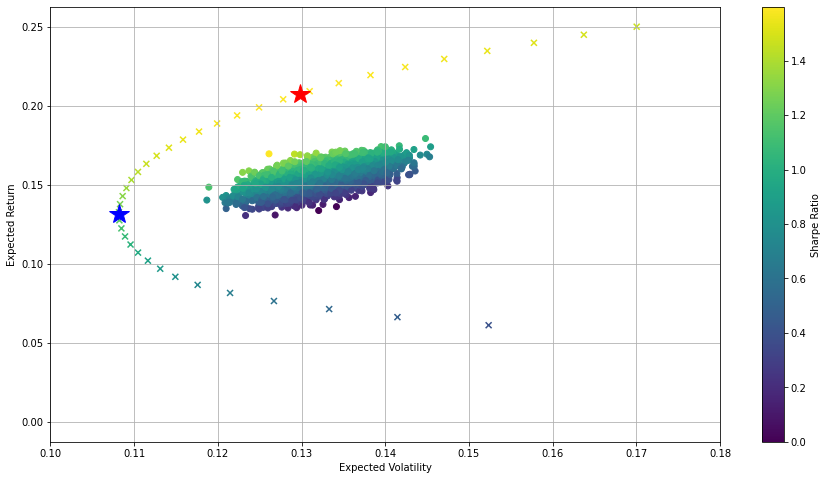

In [88]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=target_rs/target_stds, marker='x')
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.10, 0.18)
plt.colorbar(label='Sharpe Ratio')

The visualisation above shows the efficient frontier, i.e. the frontier comprised of all optimal portfolios that maximise the expected return for a given level of expected volatility. The blue star depicts the absolute minimum variance portfolio and the red star depicts the absolute maximum Sharpe ratio portfolio. Note that any portflio that lies on the frontier but is below the blue star is not an optimal or efficient portfolio as it does not dominate all other portflios in terms of expected return given a certain risk level but rather is dominated by teh others.

A question that may arise here is: why is the efficient frontier so far away from the cluster of randomly selected portfolios? For those that have seen efficient portfolios being taught at university or online will have likely seen a visualisation in which the efficient frontier appears to touch the outer bound of the cluster of randomly generated portfolios, which makes the intuitive understanding behind it more clear. The reason why that isn't the case here is that the portfolio weights used to randomly generate the random portfolios lie between 0 and 1. This means that every stock in the portfolio has at least some positive weight. As I pointed out above, in both the absolute minimum variance portflio as well as the maximum Sharpe ratio portfolio a lot of the stocks in the portflio have a weight of zero. This is because the minimisation function determined the optimal weights for each stock in the portfolio based on the stocks expected return and covariance with all other stocks. Due to the expected return and covariance profiles of some stocks, the optimal weight for those just happened to be zero. Let's investigate that further.

In order to understand this further, I will use the very first set of randomly selected weights from early in this project and include its expected return and expected volatility in the above visualisation. In the visualisation below, teh white star represents the portfolio based on the initially generated random weights.

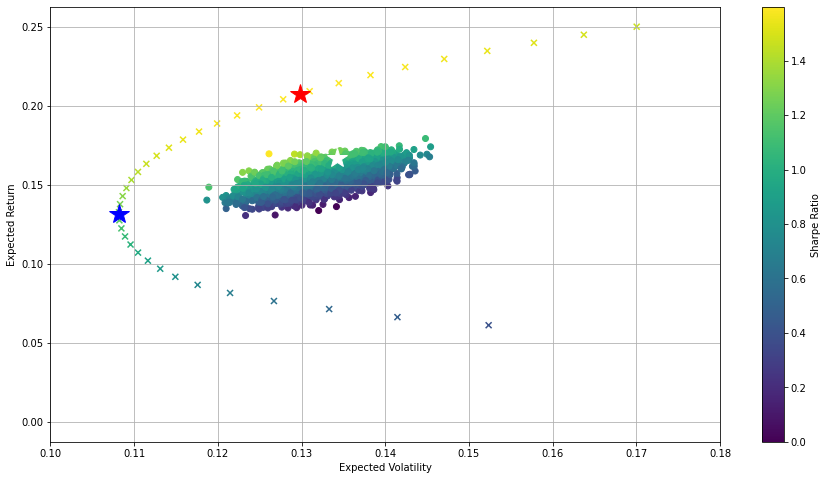

In [87]:
# Include the initially generated random weights
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=target_rs/target_stds, marker='x')
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.plot(ptf_stats(weights)[1], ptf_stats(weights)[0], 'w*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.10, 0.18)
plt.colorbar(label='Sharpe Ratio')

As we can see the white star is located towards the upper bound of the randomly generated portfolios but approximately 5% below the expected return that a portfolio on the efficient frontier would have achieved for the same amount of expected volatility. Let's look at the portfolio composition of the maximum Sharpe ratio portfolio and the one represented by the white star.

In [81]:
# Create DataFrame of the weighst assigned to each ticker
composition = {'Expected Return': annual_r.round(3), 'Maximum Sharpe': weights_opt, 'White Star': weights.round(3)}
comp = pd.DataFrame(composition, columns = ['Expected Return', 'Maximum Sharpe', 'White Star'], index=tickers)
comp

,Expected Return,Maximum Sharpe,White Star
AMZN,0.322,0.143,0.020
GOOGL,0.198,0.000,0.045
JNJ,0.114,0.000,0.006
V,0.235,0.064,0.064
PG,0.126,0.082,0.031
UNH,0.214,0.132,0.048
JPM,0.190,0.010,0.033
HD,0.171,0.000,0.018
VZ,0.104,0.000,0.060
NFLX,0.275,0.000,0.041


To get a possible explanation of why the portfolio weights are allocated the way they are I have included the expected return for each stock in the table above. For better insights we will also look at the correlation matrix.

In [84]:
# Inspect the correlation matrix
corr_matrix = log_r.corr()
corr_matrix

,AMZN,GOOGL,JNJ,V,PG,UNH,JPM,HD,VZ,NFLX,...,COST,NKE,PM,QCOM,LOW,BA,LMT,SBUX,UPS,CAT
AMZN,1.000000,0.649819,0.286694,0.575420,0.216745,0.355647,0.371625,0.412732,0.137197,0.532119,...,0.332686,0.359447,0.185083,0.281560,0.345351,0.366658,0.292841,0.405748,0.343067,0.379441
GOOGL,0.649819,1.000000,0.332688,0.599922,0.263097,0.386779,0.418049,0.432254,0.181981,0.490228,...,0.358971,0.389031,0.226371,0.317574,0.345323,0.371608,0.325861,0.428285,0.371386,0.391599
JNJ,0.286694,0.332688,1.000000,0.375575,0.389525,0.355149,0.368964,0.332502,0.375139,0.211424,...,0.366476,0.288693,0.291009,0.263940,0.251189,0.341130,0.340851,0.325391,0.326887,0.291442
V,0.575420,0.599922,0.375575,1.000000,0.336119,0.400798,0.510798,0.536668,0.226534,0.455208,...,0.380378,0.440134,0.234368,0.363641,0.410344,0.451205,0.421994,0.478528,0.426754,0.437674
PG,0.216745,0.263097,0.389525,0.336119,1.000000,0.222532,0.266850,0.320903,0.412784,0.147158,...,0.326407,0.273990,0.415937,0.197339,0.251822,0.254492,0.270084,0.332694,0.291845,0.215390
UNH,0.355647,0.386779,0.355149,0.400798,0.222532,1.000000,0.402892,0.376288,0.235914,0.327507,...,0.296585,0.298917,0.223891,0.195918,0.330623,0.325263,0.287296,0.310876,0.318439,0.320991
JPM,0.371625,0.418049,0.368964,0.510798,0.266850,0.402892,1.000000,0.477743,0.281029,0.311049,...,0.345548,0.388600,0.197215,0.366509,0.444644,0.482769,0.373842,0.349828,0.483770,0.568247
HD,0.412732,0.432254,0.332502,0.536668,0.320903,0.376288,0.477743,1.000000,0.300100,0.323793,...,0.467559,0.481536,0.249599,0.310364,0.693473,0.401434,0.364798,0.411628,0.477205,0.427521
VZ,0.137197,0.181981,0.375139,0.226534,0.412784,0.235914,0.281029,0.300100,1.000000,0.086395,...,0.297793,0.227230,0.307841,0.150073,0.250091,0.223817,0.201442,0.249390,0.272285,0.209516
NFLX,0.532119,0.490228,0.211424,0.455208,0.147158,0.327507,0.311049,0.323793,0.086395,1.000000,...,0.266048,0.316150,0.163407,0.269605,0.290780,0.320152,0.280455,0.296619,0.284865,0.312723


Looking at the composition table we can see that Amazon has the highest expected return of all stocks in the portfolio and makes up 14.3% of the maximum Sharpe ratio portfolio. Google has a relatively high expected return as well but has a weight of zero. Why might that be? 

That is where the correlation matrix comes in. Google's returns have the highest correlation with Amazon's returns (as to be expected). Therefore, despite Google's expected return being high, adding it to the portflio would not result in a lot of diversification, which gives a plausible explanation for the exclusion of its stock in the maximum Sharpe ratio portfolio. Looking at McDonald's on the other hand we can see that its stock has an expected return of 18.6% and has a relatively low correlation with Amazon's stock. Following the same logic, McDonald's stock would lead to decent diversification while maintaining a high level of expected return.

Statements like these have to be made with caution because in a portfolio allocation one cannot conclude anything by just looking at expected returns and correlation of two assets in isolatio but rather always needs to look at the portfolio as a whole. But because that is very difficult to do, the example of Amazon and Google is a good starting point to understand the underlying logic.

Comparing the asset allocation of the maximum Sharpe ratio portfolio to that of the portflio represented by the white star we can see that the latter overallocates to less "valuable" stocks (valuable here is meant in the sense of adding to diversification of the portfolio while also contributing to expected return) and underallocates to more "valuable" stocks.

## Capital Market Line

Once we have the efficient portfolio we can add a riskless asset, i.e. cash to the mix. Investing in the riskless asset and the efficient portflio greatly enhances the efficient investment opportunity set for the investor and gives them a way to find an efficient capital allocation that matches their risk appetite. By adjusting the portion of the total wealth invested in teh riskless asset, the investor can (in theory) achieve any risk-return profile that lies on the straight line between the riskless asset and the efficient portfolio (and theoretically beyond that point by borrowing).

In [85]:
# Import cubic splines interpolation module
import scipy.interpolate as sci

In [95]:
# Select the index of the absolute minimum variance portfolio
min_var = np.argmin(target_stds)

# Select expected volatilities for the stocks on the efficient frontier
ex_stds = target_stds[min_var:]

# Select expected returns for the stocks on the efficient frontier
ex_rs = target_rs[min_var:]

These ndarray objects can then be used for the interpolation. B-spline interpolation takes stes of adjacent points and constructs a ploynomial passing through those points. Essentially, what the interpolation gives us is a continuous function that approximates the efficient frontier. This function can then be differentiated in order to find the slope of the line that is tangent to the efficient frontier and passes through the riskless asset.

In [98]:
# Interpolate the B-spline representation of the data points
tck = sci.splrep(ex_stds, ex_rs)

In [109]:
# Obtain coordinates to be used for plotting the B-spline interpolation of the efficient frontier
x_lower = min(ex_stds)
x_upper = max(ex_stds)
x_range = np.linspace(x_lower, x_upper, 500)
bspline = sci.splev(x_range, tck)

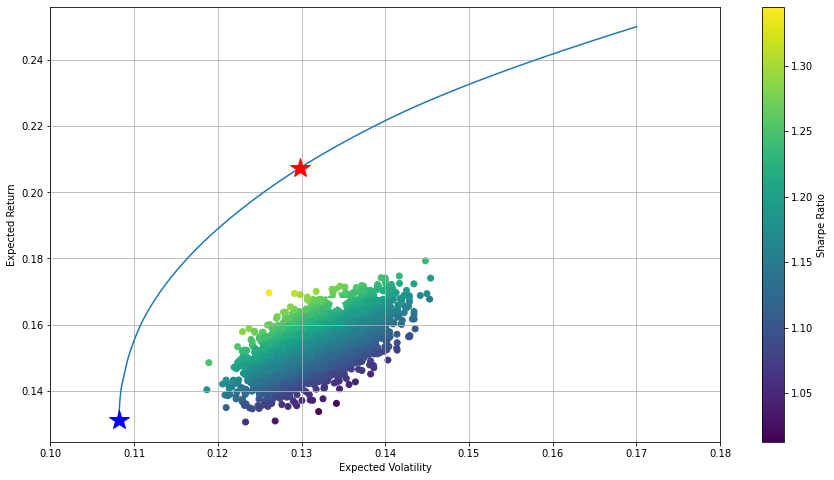

In [111]:
# Plot the B-spline interpolation of the efficient frontier
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o')
plt.plot(x_range, bspline)
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.plot(ptf_stats(weights)[1], ptf_stats(weights)[0], 'w*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.10, 0.18)
plt.colorbar(label='Sharpe Ratio')

The B-spline interpolation can be used to find a cintinuously differentiable function and, more interestingly, its derivatives.

In [112]:
# Define a continuously differentiable function f(x) for the efficient frontier
def f(x):
    return sci.splev(x, tck, der=0)

# Define te first derivate function of f(x)
def df(x):
    return sci.splev(x, tck, der=1)

Assuming a risk-free rate of return of 1% and a parameter set p=(a,b,x) we can set up a system of equations for the capital market line.

In [113]:
def cml_conditions(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

Provided with an initial parameterisation in addition to the system of equations, the optimisation function fsolve is capable of solving the system of equation.

In [116]:
# Solve for the parameters of the Capital Market Line
cml = sco.fsolve(cml_conditions, [0.01, 0.5, 0.15])

In [119]:
# Create input variable for CML
cx = np.linspace(0.0, 0.2)

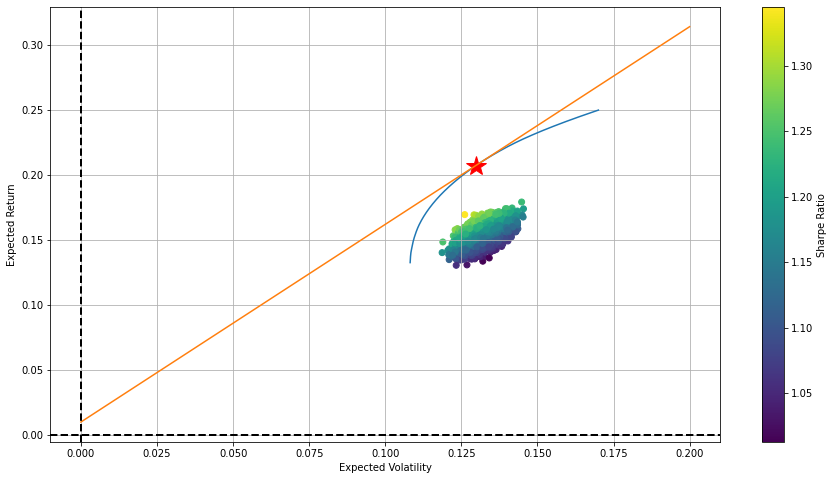

In [121]:
# Plot the resulting Capital Market Line together with the efficient frontier
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o') # Random portfolios
plt.plot(x_range, bspline) # Efficient Frontier
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0) # Maximum Sharpe ratio portfolio
plt.plot(cx, cml[0] + cml[1] * cx, lw=1.5)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

This visualisation gives the full picture in terms of where the Capital Market Line starts and puts the efficient frontier into a broader perspective in terms of where in the risk-return space it lies but I would like to get a closer view of the tangent line and the fficient frontier.

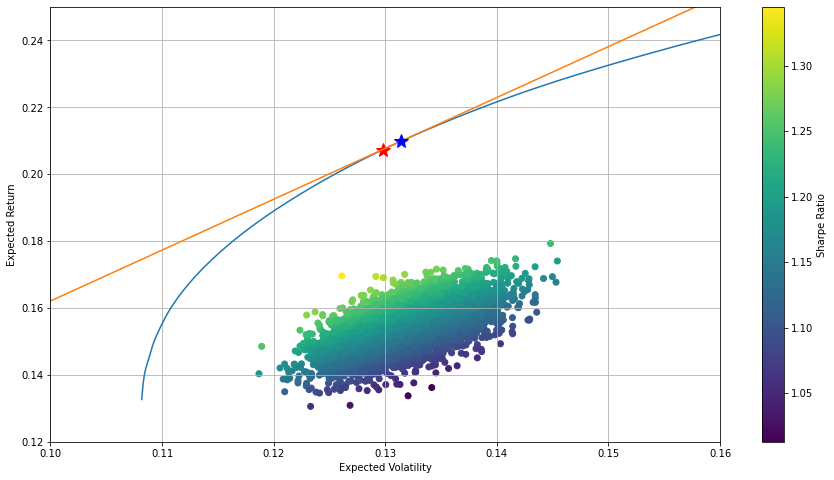

In [126]:
# Zoom in on Capital Market Line together with the efficient frontier
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_rs/ptf_stds, marker='o') # Random portfolios
plt.plot(x_range, bspline) # Efficient Frontier
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=15.0) # Maximum Sharpe ratio portfolio
plt.plot(cx, cml[0] + cml[1] * cx, lw=1.5) # Capital Market Line
plt.plot(cml[2], f(cml[2]), 'b*', markersize=15.0) # Optimal portfolio where the tangent line passes through rf
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.10, 0.16)
plt.ylim(0.12, 0.25)
plt.colorbar(label='Sharpe Ratio')

In the visualisation above, the red star represents the maximum Sharpe ratio portfolio and teh blue star represents the optimal portfolio from the efficient frontier where the tangent line passes through the riskless asset.

## Including Cryptocurrencies

Including uncorrelated assets in a portfolio can lead to better diversification. After analysing a portfolio of 30 US stocks I would like to include some other asset classes in the portfolio, namely cryptocurrencies. I will focus on Bitcoin, Ethereum, Tether and Litecoin as they are four cryptocurrencies with some of the highest market capitalisation (with Bitcoin standing out from the rest).

In [132]:
# Create a start date to ensure the crypto data timeframe is the same as that of the stocks
start = datetime(2015, 7, 7)

In [133]:
# Create a list of ticker symbols
crypto_tickers = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'LTC-USD']

In [147]:
# Obtain Bitcoin price data
btc = data.DataReader('BTC-USD', data_source='yahoo', start=start, end=end)['Adj Close']

In [153]:
# Obtain Ethereum, Tether and Litecoin
eth = data.DataReader('ETH-USD', data_source='yahoo', start=start, end=end)['Adj Close']
tet = data.DataReader('USDT-USD', data_source='yahoo', start=start, end=end)['Adj Close']
ltc = data.DataReader('LTC-USD', data_source='yahoo', start=start, end=end)['Adj Close']

Ethereum only listed on the August 6, 2015 so we'll have to drop all prices of other assets from before that date. Let's first have a look at cryptocurrencies only and then combine them with stocks.

In [166]:
# Create cryptocurrency dataframe
crypto_data = {'BTC': btc[32:-1], 'ETH': eth[:-1], 'USDT': tet[32:-1], 'LTC': ltc[32:-1]}
crypto_ps = pd.DataFrame(crypto_data)
crypto_ps

,BTC,ETH,USDT,LTC
Date,,,,
2015-08-06,279.584991,2.772120,1.000000,4.208280
2015-08-07,260.997009,0.753325,1.000000,3.854750
2015-08-08,265.083008,0.701897,1.000000,3.898590
2015-08-09,264.470001,0.708448,1.000000,3.948880
2015-08-10,270.385986,1.067860,1.000000,4.159550
...,...,...,...,...
2019-12-27,7290.088379,127.214607,1.005803,41.178173
2019-12-28,7317.990234,128.322708,1.000307,42.842522
2019-12-29,7422.652832,134.757980,1.004210,43.670658


## Plot the cryptocurrency time series

Text(0.5, 1.0, 'Normalised price movement of four cryptocurrencies')

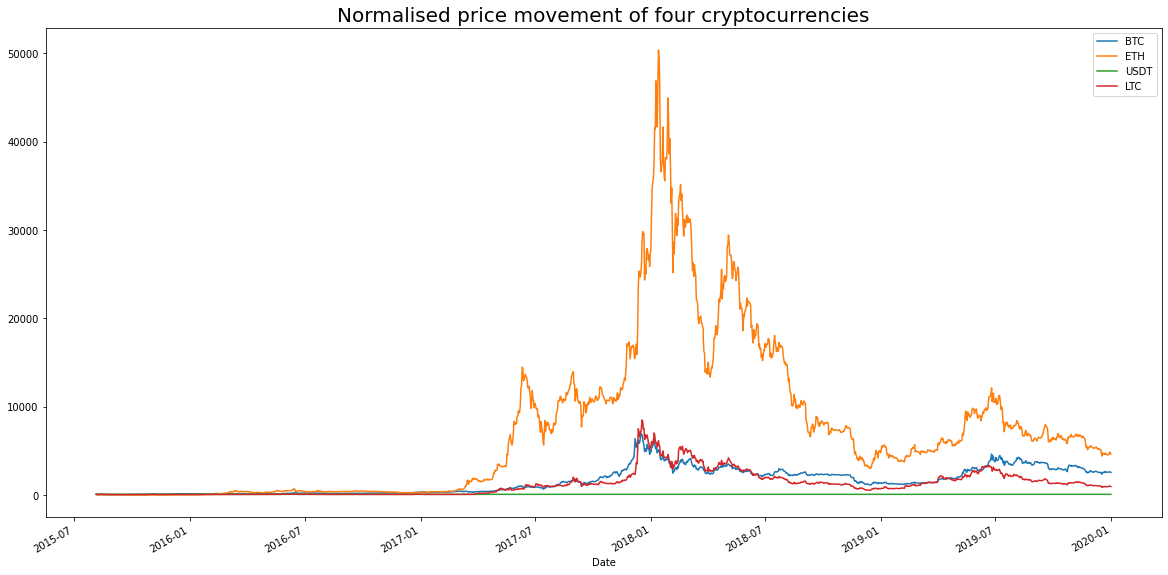

In [173]:
# Plot the time series in normalised fashion
norm = crypto_ps / crypto_ps.iloc[0] * 100
norm.plot(figsize=(20, 10))
plt.title('Normalised price movement of four cryptocurrencies', fontsize=20.0)

The above time series provides interesting insights. Firstly, in normalised terms, Ethereum experienced extreme spikes in 2018, substantially higher than the other cryptocurrencies. Secondly, it appears as though the prices of the cryptocurrencies tend to move together, i.e. be correlated. Thirdly, because the time of normalisation for the prices of these cryptocurrencies is August 6, 2015, a time when cryptocurrencies were extremely novel and at very low prices, the scale on the y-axis goes up all the way to 50,000. This is incredible, especially when compared to the equivalent graph for the 30 US stocks at the beginning of this project. The starting price of the normalisation for Ethereum is USD 2.77 and in 2018 it reached a maximum of USD 1396.42, which is almost 504 times the starting price, hence the scale of the y-axis. Interestingly, the price of Ethereum dropped drastically on its second trading day, down to $0.75. If one were to use that price as the starting price of the normalisation, the scale would not stop at 50,000 but it would actually go up to 190,000!

Let's have a look at the log returns and correlation between these cryptocurrencies.

In [174]:
# Calculate the log returns
crypto_log_r = np.log(crypto_ps / crypto_ps.shift(1))

In [175]:
# Annualise the returns
crypto_annual_r = crypto_log_r.mean() * 252
crypto_annual_r

BTC     0.509275
ETH     0.602938
USDT   -0.000050
LTC     0.358285
dtype: float64

In [176]:
# Inspect the correlation matrix
crypto_corr_matrix = crypto_log_r.corr()
crypto_corr_matrix

,BTC,ETH,USDT,LTC
BTC,1.000000,0.423776,0.056310,0.634325
ETH,0.423776,1.000000,0.034653,0.410086
USDT,0.056310,0.034653,1.000000,0.014975
LTC,0.634325,0.410086,0.014975,1.000000


Bitcoin and Litecoin have the highest correlation, Tether seems to be almost completely uncorrelated to the other three cryptocurrencies (this could be interesting for portfolio diversification), and Ethereum is moderately correlated with both Bitcoin and Litecoin.

## Combining stocks and cryptocurrencies

After having a brief look at the four cryptocurrencies, I will combine the cryptocurrencies with the stocks from the previous analysis and investigate whether the inclusion of cryptocurrencies changes optimal portfolio allocation in a mean-variance sense.

In [184]:
# Drop all price data before August 6, 2015
reduced_prices = prices.iloc[22:]

In [182]:
# Compare the length of the stock price data to that of the cryptocurrencies
len(reduced_prices), len(crypto_ps)

(1109, 1608)

There is a lot more data on cryptocurrencies than there is on traditional stocks. This is due to one of the fundamental characteristics of cryptocurrencies: they are decentralised. Decentralisation means that there is no centralised control of the currency, which is part of the currencies' attractiveness, but it also means that, unlike it is the case for stock markets, there is no centralised governance of the market. Therefore, cryptocurrencies are usually available to trade 24/7.

For this analysis this means dropping all the data points for which there is no corresponding stock market data and losing some of the data points. This is not ideal but necessary for the analysis to work.

In [186]:
# Left join the two DataFrames, thereby dropping the redundant cryptocurrency data
combined_prices = reduced_prices.merge(crypto_ps, on ='Date', how='left')

In [187]:
# Compute log returns once again
combined_log_r = np.log(combined_prices / combined_prices.shift(1))

In [188]:
# Have a look at the correlation matrix of stock prices and cryptocurrencies
combined_corr_matrix = combined_log_r.corr()
combined_corr_matrix

,AMZN,GOOGL,JNJ,V,PG,UNH,JPM,HD,VZ,NFLX,...,LOW,BA,LMT,SBUX,UPS,CAT,BTC,ETH,USDT,LTC
AMZN,1.000000,0.690651,0.294253,0.569905,0.225318,0.366482,0.377583,0.422862,0.139014,0.546597,...,0.353239,0.375019,0.299011,0.403441,0.354911,0.388500,0.001086,0.031588,0.044043,0.013534
GOOGL,0.690651,1.000000,0.356597,0.639093,0.278344,0.410081,0.438825,0.455405,0.192837,0.520865,...,0.369678,0.394889,0.343018,0.451964,0.387355,0.412524,0.011700,0.027326,0.009496,0.019521
JNJ,0.294253,0.356597,1.000000,0.377752,0.392425,0.352350,0.366029,0.329068,0.374621,0.212513,...,0.248044,0.337670,0.339032,0.322774,0.324533,0.290905,0.009594,0.007874,-0.003632,-0.005393
V,0.569905,0.639093,0.377752,1.000000,0.341025,0.406468,0.513556,0.542690,0.224025,0.474366,...,0.415171,0.455707,0.422872,0.475010,0.432211,0.444954,0.019213,0.004689,0.036774,0.028271
PG,0.225318,0.278344,0.392425,0.341025,1.000000,0.221216,0.266608,0.322789,0.416023,0.158610,...,0.253803,0.253050,0.268786,0.339017,0.296028,0.217311,-0.019152,-0.021029,-0.033259,-0.020030
UNH,0.366482,0.410081,0.352350,0.406468,0.221216,1.000000,0.401862,0.372356,0.234643,0.341283,...,0.328104,0.322416,0.287063,0.311741,0.311971,0.317490,0.006280,-0.001938,0.015860,0.002263
JPM,0.377583,0.438825,0.366029,0.513556,0.266608,0.401862,1.000000,0.475388,0.280263,0.316746,...,0.443025,0.480193,0.372414,0.346996,0.486466,0.572337,-0.006587,-0.001150,0.005270,0.012744
HD,0.422862,0.455405,0.329068,0.542690,0.322789,0.372356,0.475388,1.000000,0.301853,0.333126,...,0.692564,0.399347,0.364164,0.410140,0.475135,0.428588,0.015166,0.004613,-0.040916,0.021924
VZ,0.139014,0.192837,0.374621,0.224025,0.416023,0.234643,0.280263,0.301853,1.000000,0.085963,...,0.250630,0.220931,0.196149,0.250852,0.272677,0.208516,0.028173,0.016467,0.046202,0.009805
NFLX,0.546597,0.520865,0.212513,0.474366,0.158610,0.341283,0.316746,0.333126,0.085963,1.000000,...,0.296364,0.323737,0.283664,0.299754,0.290524,0.316929,0.032388,0.024750,0.027936,0.034426


Looking at the last four columns in the above matrix we can see that all four cryptocurrencies were mostly uncorrelated to any of the stocks. This could be an indication that including at least oe of the cryptocurrencies in the portfolio could be beneficial in a mean-variance sense.